PCA similar to the VAE in v 7.1

In [1]:
VAEversion='0'

In [2]:
from glob import glob
import os, sys, scipy, pickle
from scipy.stats import chi2, poisson
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

from prettytable import PrettyTable

In [3]:
import ROOT as rt
import root_numpy as rtnp
from utility_func import *

Welcome to JupyROOT 6.12/06


Using TensorFlow backend.


In [4]:
from sklearn.decomposition import PCA

In [5]:
do_training = 1

# Get the samples

In [6]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'allJetMass',
                       'allMuPt', 'allMuMass',
                       'allElePt','allEleMass',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'METp', 'METo',
                       
                       'MT',
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 
                       
                       'LepCharge','LepIsEle', 
                       
                       'nChHad', 'nNeuHad']

Nf_lognorm = 10
Nf_gauss = 2
Nf_Pgauss = 1
Nf_PDgauss = 4
Nf_binomial = 2
Nf_poisson = 2

sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)
# print 'Activated HLF:'
# for n in np.array(hlf_features)[sel]:
#     print '\t', n

In [7]:
data_folder = '../data/HLF_ONLY/'
TrainSamplesName = ['Wlnu', 'qcd', 'Zll', 'ttbar']
BSM_samples = ['Ato4l', 'Zprime', 'Wprime', 'leptoquark', 'hToTauTau', 'hChToTauNu']

N_train_max = int(9e6)
training_split_fraction = 0.5

In [8]:
fraction = np.array([0.592, 0.338, 0.067, 0.003])

raw_sample = {}
l = np.zeros(4)
for i,n in enumerate(TrainSamplesName):
    raw_sample[n] = np.load(data_folder+n+'_sample.npy')
#     np.random.shuffle(raw_sample[n])
    l[i] = raw_sample[n].shape[0]
    
i_min = np.argmin(l/fraction)
if TrainSamplesName[i_min]=='qcd':
    print 'QCD is limiting, using it for both val and split'
    N_train = min(N_train_max, l[i_min]/fraction[i_min])
else:
    N_train = min(N_train_max, training_split_fraction*l[i_min]/fraction[i_min])

if N_train < N_train_max:
    print 'Limiting stat. sample:', TrainSamplesName[i_min]
else:
    print 'Sample available satisfying '

N_val = N_train*(1-training_split_fraction)/training_split_fraction - 1
print 'Expected {:.2f}M train'.format(N_train/1.0e6)
print 'Expected {:.2f}M val'.format(N_val/1.0e6)

QCD is limiting, using it for both val and split
Limiting stat. sample: qcd
Expected 3.45M train
Expected 3.45M val


In [9]:
x_train_s = {}
x_val_s = {}

table = PrettyTable(['Sample', 'Evts tot', 'Train', 'Val'])

for i,n in enumerate(TrainSamplesName):
    N_train_aux = int(N_train * fraction[i])
    x_train_s[n] = raw_sample[n][:N_train_aux, sel]
    N_val_aux = int(N_val * fraction[i])
    if TrainSamplesName[i_min]=='qcd' and n == 'qcd':
        print 'QCD is limiting, using it for both val and split'
        np.random.shuffle(raw_sample[n])
        x_val_s[n] = raw_sample[n][:N_val_aux, sel]
    elif N_train_aux+N_val_aux < raw_sample[n].shape[0]:
        x_val_s[n] = raw_sample[n][N_train_aux : N_train_aux+N_val_aux, sel]
    else:
        print 'Error', n
        continue
    table.add_row([n, raw_sample[n].shape[0], x_train_s[n].shape[0], x_val_s[n].shape[0]])
print table
    
x_train = np.concatenate((x_train_s['Wlnu'], x_train_s['qcd'], x_train_s['Zll'], x_train_s['ttbar']))
x_val = np.concatenate((x_val_s['Wlnu'], x_val_s['qcd'], x_val_s['Zll'], x_val_s['ttbar']))

print 'Tot training {:.2f} M'.format(x_train.shape[0]/1.0e6)
print 'Tot val {:.2f} M'.format(x_val.shape[0]/1.0e6)

QCD is limiting, using it for both val and split
+--------+----------+---------+---------+
| Sample | Evts tot |  Train  |   Val   |
+--------+----------+---------+---------+
|  Wlnu  | 8000082  | 2042566 | 2042565 |
|  qcd   | 1166195  | 1166195 | 1166194 |
|  Zll   | 1777383  |  231168 |  231168 |
| ttbar  | 5001726  |  10350  |  10350  |
+--------+----------+---------+---------+
Tot training 3.45 M
Tot val 3.45 M


# Start the PCA declaration and fit

In [10]:
latent_dim = 4

In [11]:
pca = PCA(n_components=latent_dim)
pca = pca.fit(x_train)

# Validation

Gather the signal data

In [12]:
x_sig = {}
for n in BSM_samples+TrainSamplesName:
    s = np.load(data_folder+n+'_sample.npy')
    x_sig[n] = s[:N_train_max, sel]

Normal SingleMu CMS trigger efficiency.

pt > 30 and ISO < 0.25

In [33]:
active_hlf_features[6]

'LepPt'

In [58]:
for n, arr in x_sig.iteritems():
    if not n in BSM_samples:
        continue
    s1 = arr[:,6] > 30.
    s2 = arr[:,7] + arr[:,8] + arr[:,9] < .25
    s = np.sum(np.logical_and(s1, s2))
    print n, ': {}/{} = {:1.2e}'.format(s, arr.shape[0], float(s)/arr.shape[0])
    

hToTauTau : 223286/344917 = 6.47e-01
hChToTauNu : 269874/339018 = 7.96e-01
Wprime : 381248/605662 = 6.29e-01
Ato4l : 345104/652070 = 5.29e-01
leptoquark : 374019/583043 = 6.41e-01
Zprime : 30923/55362 = 5.59e-01


### Predict latent space

In [14]:
x_val_encoded = pca.transform(x_val)

x_sig_encoded = {}
for k,v in x_sig.iteritems():
    x_sig_encoded[k] = pca.transform(v)

Latent space mean distribution

In [19]:
histos = []
canvases = []
N_bins = 100
rt.gStyle.SetOptTitle(0)

for kk in range(latent_dim):
    print 'Plotting dim', kk, '...'
    canvas = rt.TCanvas('c'+str(kk), 'c'+str(kk), 600, 400)
    canvas.SetLeftMargin(0.16)
    canvas.SetBottomMargin(0.16)
    canvas.SetRightMargin(0.02)
    canvas.SetTopMargin(0.02)

    l_bound = mu_prior[kk] - 6*sigma_prior[kk]
    u_bound = mu_prior[kk] + 6*sigma_prior[kk]
    bin_width = (u_bound - l_bound)/N_bins
    z = np.arange(l_bound, u_bound, bin_width)
    
    bin_content = sum_of_gaussians(z, x_val_encoded[0, :, kk], x_val_encoded[1, :, kk])*bin_width
    print '\t SMMix coverage: {:.3f}'.format(np.sum(bin_content))
    h = rt.TH1F('h_SMMix_{}'.format(kk), 'SMMix', N_bins, l_bound-bin_width/2., u_bound+bin_width/2.)
    for i,c in enumerate(bin_content): 
        h.SetBinContent(i+1, c)
    h.GetYaxis().SetRangeUser(1e-5, 0.9)
    h.SetStats(0)
    h.SetLineWidth(0)
    h.SetFillColorAlpha(rt.kGreen+2, 0.7)
    h.SetFillStyle(3001)
    
    h.SetXTitle('z_{'+str(kk)+'}')
    h.GetXaxis().SetTitleSize(0.06)
    h.GetXaxis().SetLabelSize(0.06)
    h.SetYTitle('p.d.f.')
    h.GetYaxis().SetTitleSize(0.06)
    h.GetYaxis().SetTitleOffset(1.16)
    h.GetYaxis().SetLabelSize(0.06)    
    
    h.Draw('Bar')
    histos.append(h)


    colors = [1,2,4,rt.kYellow+2,6,7,8,46, 30, 40]
    # fill
    for i, n in enumerate(x_sig.keys()):
        bin_content = sum_of_gaussians(z, x_sig_encoded[n][0, :, kk], x_sig_encoded[n][1, :, kk])*bin_width
        print '\t {} coverage: {:.3f}'.format(n, np.sum(bin_content))
        h = rt.TH1F('h_{}_{}'.format(n, kk), n, N_bins, l_bound-bin_width/2., u_bound+bin_width/2.)
        for j,c in enumerate(bin_content): 
            h.SetBinContent(j+1, c)

        h.SetStats(0)
        h.SetLineColor(colors[i])
        h.SetLineWidth(2)
        h.Draw('SAME')
        histos.append(h)
    leg = canvas.BuildLegend(0.8, 0.6, 0.99, 0.99, '','lf')
        
    line = rt.TLine()
    line.SetLineWidth(2)
    line.SetLineStyle(9)
    line.SetLineColor(9)
    l = line.DrawLine(mu_prior[kk], 1e-5, mu_prior[kk], 0.9)
    leg.AddEntry(l, 'Prior Mean', 'l')
    line.SetLineColor(40)
    l = line.DrawLine(mu_prior[kk]-sigma_prior[kk], 1e-5, mu_prior[kk]-sigma_prior[kk], 0.9)
    leg.AddEntry(l, 'Prior Sigma', 'l')
    
    line.DrawLine(mu_prior[kk]+sigma_prior[kk], 1e-5, mu_prior[kk]+sigma_prior[kk], 0.9)
    
    canvas.SetGrid()
    canvas.SetLogy()
    canvas.Draw()
    canvas.Update()
    canvases.append(canvas)
    
fout = rt.TFile('plots/all-in-one_v'+VAEversion+'_Zpdf.root', 'RECREATE')
for obj in canvases + histos:
    obj.Write()

fout.Close()

Plotting dim 0 ...


NameError: name 'mu_prior' is not defined

## Recostruction sum of pdf

In [15]:
out_pca_val = pca.inverse_transform(x_val_encoded)

HT


NameError: name 'pars_ae_val' is not defined

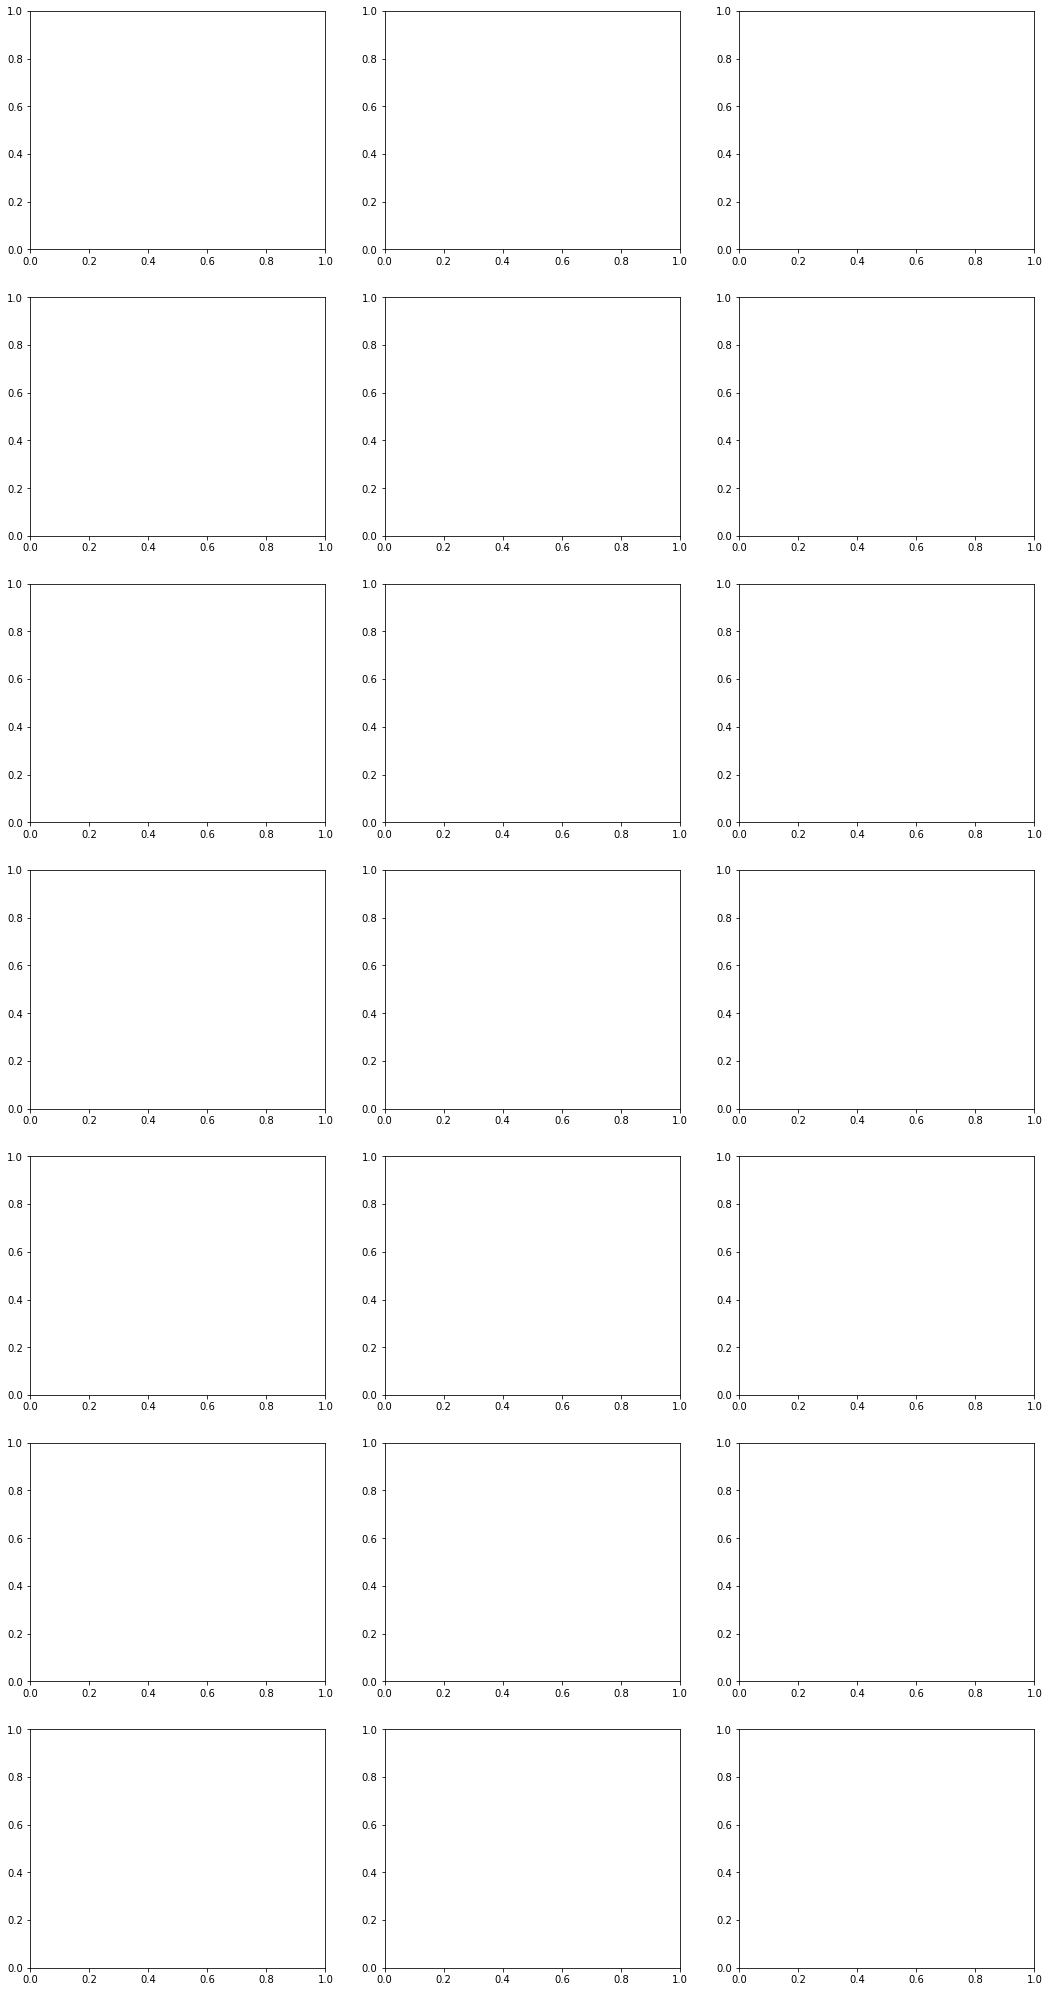

In [16]:
f, ax_arr = plt.subplots(int(len(active_hlf_features)/3.),3 , figsize=(18,36))
N_bins = 100
for i,hlf_name in enumerate(active_hlf_features):
    print hlf_name
    
    #Plot distribution of the variable
    x_aux = x_val[:, i]
    if i < Nf_lognorm:
        histo_range = (0, np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        if np.sum(bin_edges>clip_x_to0) > 0:
            i_aux = np.argmin(bin_edges<clip_x_to0)
            bin_edges = np.concatenate((np.array([0, clip_x_to0]), bin_edges[i_aux:]))
        else:
            bin_edges = np.array([0, clip_x_to0])
        bin_content, bin_edges = np.histogram(x_aux, bins=bin_edges, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
        bin_width[0] = 1.

        mu_vec = pars_ae_val[0][:, i]
        sigma_vec = pars_ae_val[1][:, i]
        f_vec = pars_ae_val[2][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_lognorm(bincenters, f_vec, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_val[0][:, i]
        sigma_vec = pars_ae_val[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_gaussians(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_val[0][:, i]
        sigma_vec = pars_ae_val[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_Pgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss:
        Nmax = int(np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_val[0][:, i]
        sigma_vec = pars_ae_val[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_PDgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss + Nf_binomial:
        bin_content, bin_edges = np.histogram(x_aux, bins=2, range=(np.min(x_aux), np.max(x_aux)))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        p = 0.5*(1+0.98*np.tanh(pars_ae_val[0][:, i]))

        spdf_bin_content = np.zeros_like(bincenters)
        spdf_bin_content[np.nonzero(bin_content)[0][1]] = np.sum(p)
        spdf_bin_content[np.nonzero(bin_content)[0][0]] = np.sum(1-p)
    else:
        Nmax = int(np.percentile(x_aux, 99.5))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        aux = pars_ae_val[0][:, i]
        mu_vec = 1 + np.where(np.greater(aux, 0), aux, np.divide(aux, np.sqrt(1+np.square(aux))))
        spdf_bin_content = sum_of_possion(bincenters, mu_vec)


    if i < Nf_lognorm:
        bin_width[0] = clip_x_to0
        
    ax_arr[i/3, i%3].errorbar(bincenters, bin_content, xerr=bin_width/2., yerr=np.sqrt(bin_content), fmt='.b', label='input')
    ax_arr[i/3, i%3].errorbar(bincenters, spdf_bin_content, xerr=bin_width/2., fmt='.r', label='spdf')
    ax_arr[i/3, i%3].ticklabel_format(axis='y', style='sci')
    ax_arr[i/3, i%3].grid()
    ax_arr[i/3, i%3].set_title(hlf_name + ' - SMMix')        
    ax_arr[i/3, i%3].legend(loc='best')
    
    if hlf_name.startswith('LepIso') or hlf_name.startswith('all'):
        ax_arr[i/3, i%3].set_yscale('log')
        
        
f.savefig('plots/SMMix_SumOfPdfs_v'+VAEversion+'.pdf')        
plt.show()

# Test Statistics with Losses

In [22]:
print 'SMMix', x_train.shape
out = x_train - pca.inverse_transform(pca.transform(x_train))
loss_train = np.array([np.average(np.square(out), axis=1)])

loss_sig = {}
for n in x_sig.keys():
    print n, x_sig[n].shape
    out = x_sig[n] - pca.inverse_transform(pca.transform(x_sig[n]))
    loss_sig[n] = np.array([np.average(np.square(out), axis=1)])

SMMix (3450279, 21)
hToTauTau (344917, 21)
Zll (1777383, 21)
qcd (1166195, 21)
Wlnu (8000082, 21)
hChToTauNu (339018, 21)
Wprime (605662, 21)
Ato4l (652070, 21)
leptoquark (583043, 21)
Zprime (55362, 21)
ttbar (5001726, 21)


In [23]:
BSM_labels = {'Ato4l':r'$A\to 4\ell$', 
              'leptoquark':r'$LQ$', 
              'hToTauTau':r'$h^{0}\to \tau\tau$', 
              'hChToTauNu':r'$h^{\pm}\to \tau\nu$'}

/Users/olmo/programs/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


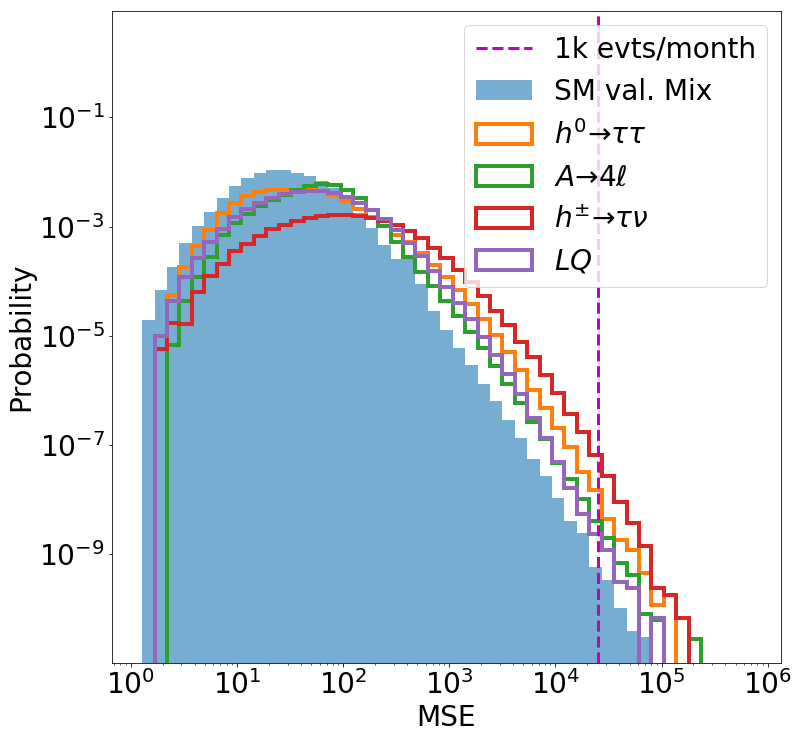

In [24]:
matplotlib.rcParams.update({'font.size': 28})
histos = []
canvases = []
x_axis_titles = ['MSE', '$Loss_{reco}$', '$D_{KL}$']

eff_SMMix = 5.38E-06

f, ax_arr = plt.subplots(1, 1, figsize=(12, 12))

for loss_piece in range(1):
    up_end = 10*np.max(loss_train[loss_piece])
    dwn_end = max(1e-1, np.min(loss_train[loss_piece]))
    bins = np.logspace(start=np.log10(dwn_end), stop=np.log10(up_end), num=50)
    
    i_ax = loss_piece-1
    ax_arr.hist(loss_train[loss_piece], bins=bins, normed=True, label='SM val. Mix', alpha=0.6)
    
    for n, loss in loss_sig.iteritems():
        if n in BSM_labels.keys():
            ax_arr.hist(loss[loss_piece], 
                              bins=bins, normed=True, 
                              histtype='step',
                              lw=4,
                              label=BSM_labels[n])
            
    ax_arr.set_yscale('log')
    ax_arr.set_xscale('log')
    ax_arr.set_xlabel(x_axis_titles[loss_piece])
    ax_arr.set_ylabel('Probability')
    ax_arr.set_ylim(ax_arr.set_ylim()[0], 9)
    
    q = np.percentile(loss_train[loss_piece], 100*(1-eff_SMMix))
    ys = list(ax_arr.set_ylim())
    ax_arr.plot([q, q], ys, lw = 3, color='m', ls='--', label='1k evts/month')
    
    ax_arr.legend(loc='best')
    
f.subplots_adjust(wspace=0.2)
f.savefig('../fig/LossesPDF_PCA_v'+VAEversion+'.png', bbox_inches='tight')

In [29]:
SM_evts_per_month = 1000
SM_tot_xsec = 37.205e6 #fb

lumi_per_yr = 40 #fb^-1
DataColl_month = 8.

eff_SMMix = SM_evts_per_month/(SM_tot_xsec * lumi_per_yr/DataColl_month)
print 'Ideal Eff SM --->> {:.2e}\n\n\n'.format(eff_SMMix)

for ll in range(1):
    cut = np.percentile(loss_train[ll], 100*(1-eff_SMMix))
    
    print '---------------- MSE ----------------'
    table_SM = PrettyTable(['Sample', 'PCA Eff','Events fraction', 'evts/month'])
    table_BSM = PrettyTable(['Sample', 'PCA Eff', 'xsec (100 evts/month) [fb]', 'xsec (S/B = 0.3) [fb]'])
    
    N_SM_imp = 0
    dN_SM_imp = 0
    effSM_imp = 0
    deffSM_imp = 0
    for n, lss in loss_sig.items():
        if n in TrainSamplesName:
            aux = np.greater(lss[ll,:], cut)
            selected = np.sum(aux)
            eff = float(selected)/lss.shape[1]
            d_eff = np.sqrt(eff*(1-eff)/lss.shape[1])

            idx = TrainSamplesName.index(n)
            
            effSM_imp += fraction[idx]*eff
            deffSM_imp += (fraction[idx]*d_eff)**2
            
            N_evts = SM_tot_xsec*fraction[idx]*eff*lumi_per_yr/DataColl_month
            d_N_evts = N_evts*d_eff/eff
            N_SM_imp += N_evts
            dN_SM_imp += d_N_evts**2
            
    dN_SM_imp = np.sqrt(dN_SM_imp)
    deffSM_imp = np.sqrt(deffSM_imp)
    
    
    for n, lss in loss_sig.items():
        aux = np.greater(lss[ll,:], cut)
        selected = np.sum(aux)
        eff = float(selected)/lss.shape[1]
        d_eff = np.sqrt(eff*(1-eff)/lss.shape[1])
        
        if n in TrainSamplesName:
            idx = TrainSamplesName.index(n)
            N_evts = SM_tot_xsec*fraction[idx]*eff*lumi_per_yr/DataColl_month
            d_N_evts = N_evts*d_eff/eff
            table_SM.add_row([n,
                              '{:1.1e} +/- {:1.1e}'.format(eff, d_eff), 
                              '{:.2f} %'.format(100*float(N_evts/N_SM_imp)),
                              '{:.0f} +/- {:.0f}'.format(N_evts, d_N_evts)])
        else:
            if eff == 0:
                print n, eff
                continue
            x_sec_lim = 100. * DataColl_month/(lumi_per_yr * eff)
            x_sec_SoB = 0.3 * N_SM_imp * DataColl_month/(lumi_per_yr * eff)
            table_BSM.add_row([n, 
                               '{:1.1e} +/- {:1.1e}'.format(eff, d_eff), 
                               '{:.1f}'.format(x_sec_lim), 
                               '{:1.1e}'.format(x_sec_SoB)])


    print table_SM
    print 'Eff VAE SM: {:.2e} +/- {:.2e}'.format(effSM_imp, deffSM_imp)
    print 'Expected SM evts/month: {:.0f} +/- {:.0f}'.format(N_SM_imp , dN_SM_imp)
    print table_BSM
    print '\n\n'

Ideal Eff SM --->> 5.38e-06



---------------- MSE ----------------
Zprime 0.0
+--------+---------------------+-----------------+------------+
| Sample |       PCA Eff       | Events fraction | evts/month |
+--------+---------------------+-----------------+------------+
|  Zll   | 1.9e-05 +/- 3.3e-06 |     19.05 %     | 238 +/- 41 |
|  Wlnu  | 5.1e-06 +/- 8.0e-07 |     45.10 %     | 564 +/- 88 |
|  qcd   | 1.7e-06 +/- 1.2e-06 |      8.62 %     | 108 +/- 76 |
| ttbar  | 6.1e-04 +/- 1.1e-05 |     27.23 %     | 341 +/- 6  |
+--------+---------------------+-----------------+------------+
Eff VAE SM: 6.73e-06 +/- 6.65e-07
Expected SM evts/month: 1251 +/- 124
+------------+---------------------+----------------------------+-----------------------+
|   Sample   |       PCA Eff       | xsec (100 evts/month) [fb] | xsec (S/B = 0.3) [fb] |
+------------+---------------------+----------------------------+-----------------------+
| hToTauTau  | 1.1e-04 +/- 1.8e-05 |          186441.6          |  

## ROC Curves

In [30]:
print i_min

1


In [31]:
l = np.zeros(4)
for i,n in enumerate(TrainSamplesName):
    l[i] = loss_sig[n].shape[1]
    
i_min = np.argmin(l/fraction)
print 'Limiting stat. sample: {} ({:.2f}M)'.format(TrainSamplesName[i_min], l[i_min]*1e-6)

weight = []
for i,n in enumerate(TrainSamplesName):
    w = np.float128(fraction[i]/ fraction[i_min]) * np.float128(l[i_min]/l[i])
    weight.append(w)
weight

Limiting stat. sample: qcd (1.17M)


[0.2553181818052045295, 1.0, 0.13006134938893120572, 0.0020694542634415144572]

CumSum accuracy: 0.999999999999956678


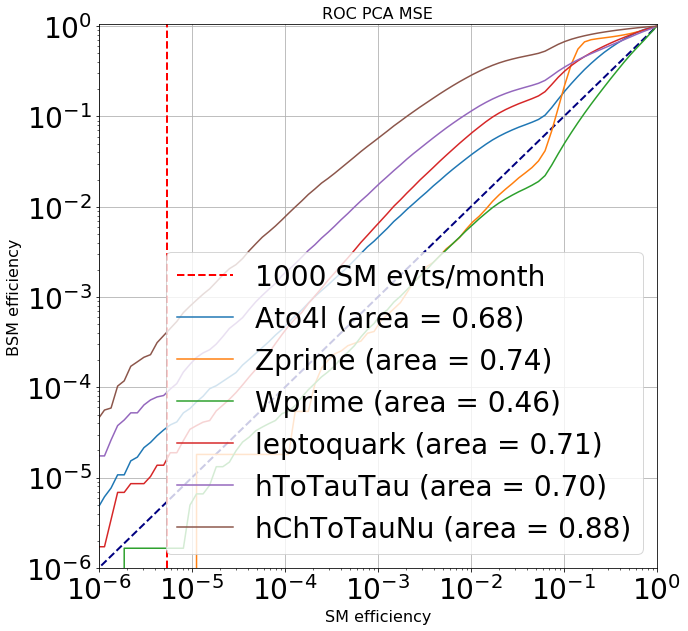

In [32]:
p_SM = np.logspace(base=10, start=-7, stop=0, num=100)
p_SM[-1] = 0.999

for ll in range(1):
    f_ROC, ax_arr_ROC = plt.subplots(1,1, figsize=(10,10))
    ax_arr_ROC.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax_arr_ROC.plot([eff_SMMix, eff_SMMix], [1e-6, 1.05], color='red', lw=2, linestyle='--', label='1000 SM evts/month')
    ax_arr_ROC.set_xlim([1e-6, 1.0])
    ax_arr_ROC.set_ylim([1e-6, 1.05])
    ax_arr_ROC.set_xlabel('SM efficiency', fontdict={'size': 16})
    ax_arr_ROC.ticklabel_format()
    ax_arr_ROC.set_ylabel('BSM efficiency', fontdict={'size': 16})
    ax_arr_ROC.set_title('ROC PCA MSE', fontdict={'size': 16})
    ax_arr_ROC.set_yscale('log')
    ax_arr_ROC.set_xscale('log')
    ax_arr_ROC.grid()

    t_SM = np.concatenate((loss_sig['Wlnu'][ll], 
                           loss_sig['qcd'][ll],
                           loss_sig['Zll'][ll],
                           loss_sig['ttbar'][ll]
                          ))
    
    w_SM = np.concatenate((np.full_like(loss_sig['Wlnu'][ll], weight[0], np.float128),
                           np.full_like(loss_sig['qcd'][ll], weight[1], np.float128),
                           np.full_like(loss_sig['Zll'][ll], weight[2], np.float128),
                           np.full_like(loss_sig['ttbar'][ll], weight[3], np.float128)
                          ))
    
    i_sort = np.argsort(t_SM)
    
    t_SM = t_SM[i_sort]
    w_SM = w_SM[i_sort]
    
    cum_sum = np.cumsum(w_SM, dtype=np.float128)/np.float128(l[i_min]/fraction[i_min])
    print 'CumSum accuracy:', cum_sum[-1]
    
    idx_q = np.argmax(cum_sum>np.atleast_2d(1-p_SM).T, axis=1)
    q_SM = t_SM[idx_q]
    
    for n in BSM_samples:
        out = loss_sig[n][ll] > np.atleast_2d(q_SM).T
        p_BSM = np.float64(np.sum(out, axis=1, dtype=np.float128)/loss_sig[n].shape[1])
        
        roc_auc = np.trapz(p_BSM, p_SM)
        
        dic2save = {'eff_BSM':p_BSM, 'eff_SM':p_SM, 'roc_auc':roc_auc}
        fileout = open('VAE_all-in-one_v{}_ROC{}_dict_{}.pkl'.format(VAEversion, ll, n), 'w')
        pickle.dump(file=fileout, obj=dic2save)
        fileout.close()
    
        ax_arr_ROC.plot(p_SM, p_BSM, label='{} (area = {:0.2f})'.format(n, roc_auc))
        
    ax_arr_ROC.legend(loc="lower right")
    f_ROC.savefig('plots/ROC_PCA'+str(ll)+'.png')
